#**Aprendizaje Automático** - 2023
# Clase 14: Redes neuronales convolucionales - Fashion MNIST

*Trabajaron en esta notebook: Sofia Del Pozo, Diego Onna, Gastón Bujía*

## Contenido
## Contenido
* [1. Análisis exploratorio de datos](#1)
* [2. Consigna](#2)
    * [2.1 Preparación de datos](#2-1)
    * [2.2 Modelo base](#2-2)
    * [2.3 Evaluación del modelo base](#2-3)
    * [2.4 Exploren el hiperparámetro](#2-4)

<a name='1'></a>
## 1 - Análisis exploratorio de datos

In [1]:
### Importamos librerías
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

import sklearn as sk
from sklearn import model_selection
from sklearn import metrics
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D
from keras.utils import to_categorical
import keras.regularizers as regularizers

tf.config.experimental.enable_op_determinism()

In [2]:

from keras.datasets import fashion_mnist
from matplotlib import pyplot

# get training and testing vectors
(train_X, train_y), (test_X, test_y) = fashion_mnist.load_data()
#train_set, test_set = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
#printing the shapes of vectors
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


In [3]:

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

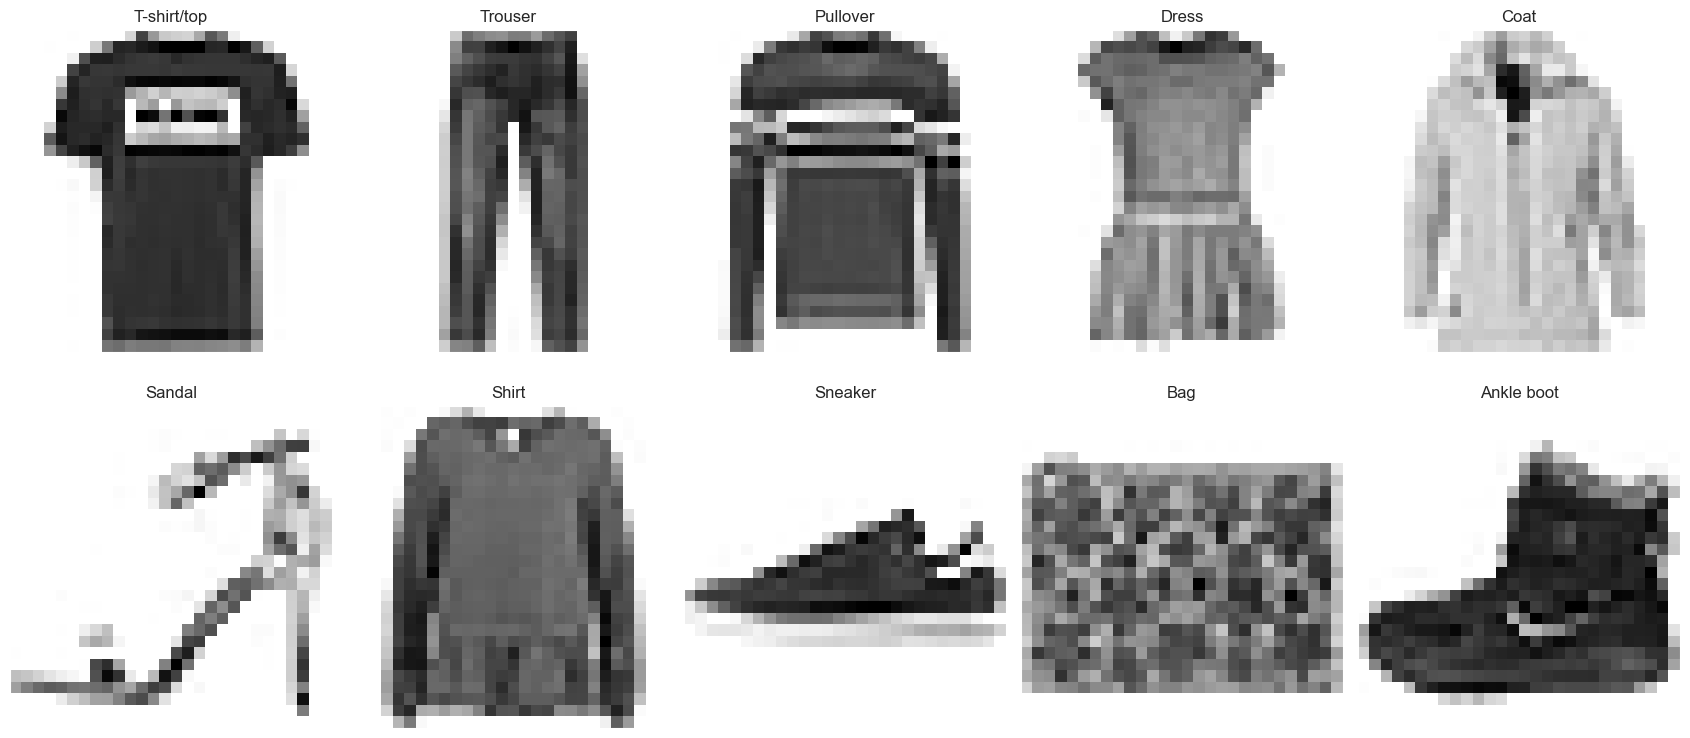

In [4]:
plt.figure(figsize=(17,8))
for i,label_val in enumerate(np.unique(train_y)):
    label_idxs = np.argwhere(train_y == label_val)
    plt.subplot(2,5,i+1)
    plt.title(class_names[label_val])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.squeeze(train_X[label_idxs[0]]),cmap='binary')
plt.tight_layout()

In [5]:
#rango de valores
print('X_train_max: ' + str(train_X.max()))
print('X_test_min:  '  + str(train_X.min()))

X_train_max: 255
X_test_min:  0


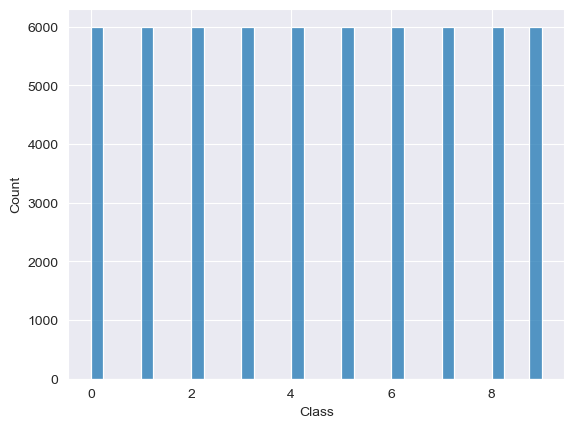

In [6]:
#distribucion de clases
sns.histplot(train_y)
plt.xlabel('Class')
plt.show()

<a name='2'></a>
## 2 - Consigna

Recordemos los conceptos importantes a llevarse de este taller:

1. Aproximación conceptual
    - Arquitectura base, (1) **profundidad**
2. Conceptos elementales
    - Operación de convolución
    - Capas de pooling
        - (2) **Función de activación capas ocultas**
3. Optimizaciones prácticas
    - (3) **Inicialización de pesos**
    - (4) **Regularización** y (5) **Dropout**
4. Secuencia de entrenamiento:
    - (6) **LR base**
    - (7) **optimizadores**
    - (8) **Batch-size**

Vamos a armar un modelo base sobre el cuál ustedes tendrán que trabajar modificando dichos hiperpárametros según el grupo que les haya tocado.

<a name='2-1'></a>
### 2.1 Preparación de datos

In [12]:
x_train = np.expand_dims(train_X, -1)
x_test = np.expand_dims(test_X, -1)

# Normalizar los valores de los píxeles
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

# Convertir las etiquetas en vectores one-hot
y_train = tf.keras.utils.to_categorical(train_y, 10)
y_test = tf.keras.utils.to_categorical(test_y, 10)

In [13]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state=42, train_size=0.8)

<a name='2-2'></a>
### 2.2 Modelo base

Armaremos un modelo que tenga 3 capas convolucionales y 2 capas fully-connected. Definamos en las siguientes dos celdas la arquitectura

#### Arquitectura

In [14]:
# activacion para todas las capas menos la salida
activacion = 'relu'

# Tasa de dropout
dropout_rate = 0.2

# Regularización
penalizacion = 0.01
reg_kernel = regularizers.L2(l2=penalizacion)

# Inicializacion de pesos - Reproducibilidad
global_seed = 2023
keras.utils.set_random_seed(global_seed)
inicializadores = tf.keras.initializers.GlorotUniform(seed=global_seed)


In [15]:
# profundidad?
def crear_modelo(
        input_shape = x_train.shape[1:],
        activation = activacion,
        dropout_rate = 0.25,
        inicializador = inicializadores,
        regularizador = reg_kernel
    ):

    # Inicializacion del modelo
    model = tf.keras.models.Sequential()

    # Bloque convolucional - 1
    model.add(tf.keras.layers.BatchNormalization(input_shape=input_shape))
    model.add(tf.keras.layers.Conv2D(64, kernel_size=(5, 5), padding='same', activation=activation,
                                     kernel_initializer = inicializador, bias_initializer = inicializador,
                                     kernel_regularizer = regularizador))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    model.add(tf.keras.layers.Dropout(dropout_rate))

    # Bloque convolucional - 2
    model.add(tf.keras.layers.BatchNormalization(input_shape=input_shape))
    model.add(tf.keras.layers.Conv2D(128, kernel_size=(5, 5), padding='same', activation=activation,
                                     kernel_initializer = inicializador, bias_initializer = inicializador,
                                     kernel_regularizer = regularizador))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(dropout_rate))

    # Bloque convolucional - 3
    model.add(tf.keras.layers.BatchNormalization(input_shape=input_shape))
    model.add(tf.keras.layers.Conv2D(256, kernel_size=(5, 5), padding='same', activation=activation,
                                     kernel_initializer = inicializador, bias_initializer = inicializador,
                                     kernel_regularizer = regularizador))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    model.add(tf.keras.layers.Dropout(dropout_rate))

    # Capas de clasificación
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation=activation,
                                    kernel_initializer = inicializador, bias_initializer = inicializador,
                                    kernel_regularizer = regularizador))
    model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Dense(10, activation='softmax',
                                    kernel_initializer = inicializador, bias_initializer = inicializador,
                                    kernel_regularizer = regularizador))

    return model

In [16]:
model = crear_modelo()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_3 (Batc  (None, 28, 28, 1)        4         
 hNormalization)                                                 
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        1664      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 batch_normalization_4 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                      

#### Entrenamiento

Ahora definiremos aquí los hipeparámetros de optimización del modelo y nos guardaremos la historia del mismo. En este caso solo utilizamos `accuracy` como métrica adicional, agreguen las que crean necesarias.

In [17]:
# LR y optimizadores
LR = 1e-3
optim=tf.keras.optimizers.Adam(learning_rate=LR)

# batch_size/epochs
batch_size = 1024
num_epochs = 15

model.compile(
    optimizer=optim,
    loss='categorical_crossentropy',
    metrics=['accuracy'])

historia = model.fit(
                    x = x_train,
                    y = y_train,
                    batch_size = batch_size,
                    epochs = num_epochs,
                    validation_data=(x_val, y_val),
                    )

Epoch 1/15
47/47 [==============================] - 94s 2s/step - loss: 6.6542 - accuracy: 0.6762 - val_loss: 6.0599 - val_accuracy: 0.1015
Epoch 2/15
47/47 [==============================] - 97s 2s/step - loss: 3.0080 - accuracy: 0.8195 - val_loss: 3.9735 - val_accuracy: 0.1019
Epoch 3/15
47/47 [==============================] - 96s 2s/step - loss: 1.5425 - accuracy: 0.8580 - val_loss: 3.2007 - val_accuracy: 0.1024
Epoch 4/15
47/47 [==============================] - 97s 2s/step - loss: 0.9803 - accuracy: 0.8753 - val_loss: 2.8481 - val_accuracy: 0.1021
Epoch 5/15
47/47 [==============================] - 99s 2s/step - loss: 0.7544 - accuracy: 0.8832 - val_loss: 2.7797 - val_accuracy: 0.1026
Epoch 6/15
47/47 [==============================] - 98s 2s/step - loss: 0.6623 - accuracy: 0.8852 - val_loss: 2.7280 - val_accuracy: 0.1702
Epoch 7/15
47/47 [==============================] - 103s 2s/step - loss: 0.5964 - accuracy: 0.8926 - val_loss: 2.6748 - val_accuracy: 0.1386
Epoch 8/15
47/47 [=

<a name='2-3'></a>
### 2.3 Evaluación del modelo base

Ahora que nuestro modelo está entrenado, vamos a visualizar las métricas resultantes: pérdida (loss) y accuracy durante el entrenamiento y la validación. Además veremos la matriz de confusión para ver que tan bien esta clasificando nuestro modelo. ¿Qué otras métricas les parece interesante mirar?

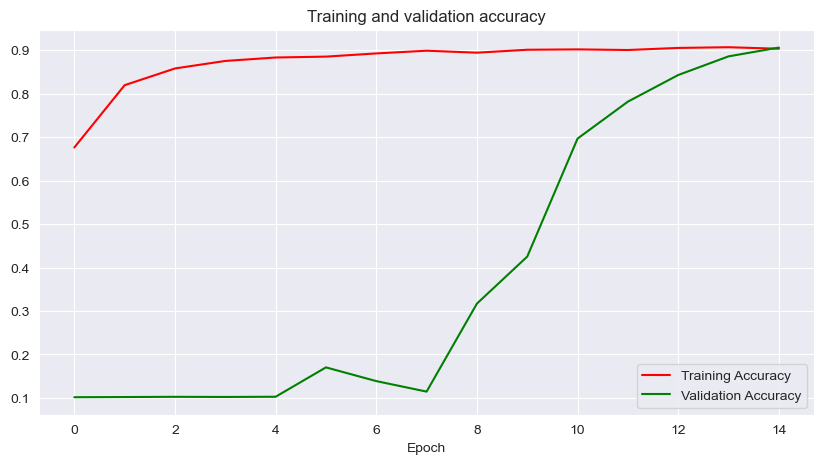

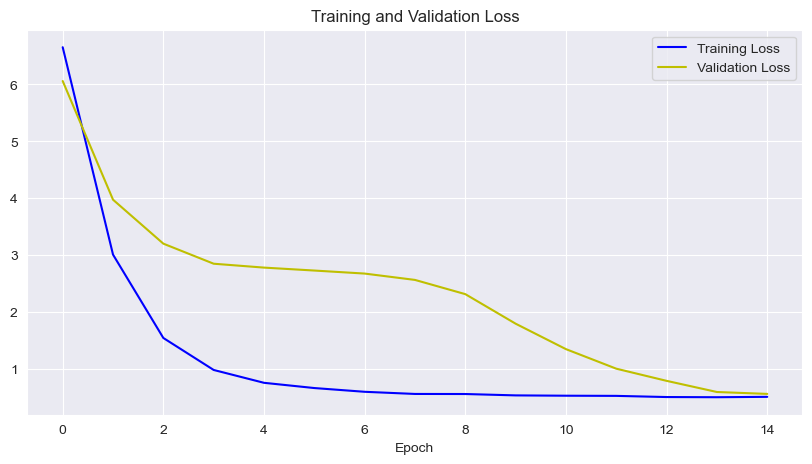

In [18]:
model_history = historia.history
acc = model_history['accuracy']
val_acc = model_history['val_accuracy']
loss = model_history['loss']
val_loss = model_history['val_loss']

epochs = historia.epoch

# función para graficar la precisión

def plot_acc(acc, val_acc, epochs):

  plt.figure(figsize=(10,5))
  plt.plot(epochs, acc, 'r', label='Training Accuracy')
  plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epoch')
  plt.legend(loc=0)
  plt.show()

def plot_loss(loss, val_loss, epochs):

  plt.figure(figsize=(10,5))
  plt.plot(epochs, loss, 'b', label='Training Loss')
  plt.plot(epochs, val_loss, 'y', label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epoch')
  plt.legend(loc=0)
  plt.show()

plot_acc(acc, val_acc, epochs)
plot_loss(loss, val_loss, epochs)

<a name='2-4'></a>
### 2.4 Exploren el hiperparámetro

Creen al menos tantos modelos como hiperparámetros les corresponde explorar.

In [ ]:
#### COMPLETAR

Comparen los resultados en test de todos los modelos considerados, incluyendo el modelo base.

In [ ]:
#### COMPLETAR